In [13]:
!cd TF_model
!git clone https://github.com/tensorflow/models/

/bin/bash: line 1: cd: TF_model: No such file or directory
Cloning into 'models'...
remote: Enumerating objects: 97415, done.
remote: Counting objects: 100% (695/695), done.
remote: Compressing objects: 100% (322/322), done.
remote: Total 97415 (delta 420), reused 580 (delta 367), pack-reused 96720
Receiving objects: 100% (97415/97415), 613.67 MiB | 18.46 MiB/s, done.
Resolving deltas: 100% (70838/70838), done.


In [33]:
import os
import sys
import tensorflow as tf

os.chdir('/content/TF_model/models/research/slim')

sys.path.append('/content/TF_model/models/research/slim')
sys.path.append('/content/TF_model/models/research')

from nets import cifarnet
images = tf.random.uniform([1, 32, 32, 3])
logits, _ = cifarnet.cifarnet(images)


print(logits)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer.py:2213: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


tf.Tensor(
[[ 0.00825196  0.00246057 -0.0084666   0.0124972   0.01519823 -0.00862919
   0.00266577  0.00401886 -0.00614509 -0.00124893]], shape=(1, 10), dtype=float32)


In [2]:
pip install --upgrade tf_slim

In [3]:
import tf_slim as slim

In [5]:
eval = slim.evaluation.evaluate_once

In [34]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow.compat.v1 as tf
import time

from datasets import dataset_utils

# Main slim library
import tf_slim as slim

In [35]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
    """Creates the regression model.

    Args:
        inputs: A node that yields a `Tensor` of size [batch_size, dimensions].
        is_training: Whether or not we're currently training the model.
        scope: An optional variable_op scope for the model.

    Returns:
        predictions: 1-D `Tensor` of shape [batch_size] of responses.
        end_points: A dict of end points representing the hidden layers.
    """
    with tf.variable_scope(scope, 'deep_regression', [inputs]):
        end_points = {}
        # Set the default weight _regularizer and acvitation for each fully_connected layer.
        with slim.arg_scope([slim.fully_connected],
                            activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(0.01)):

            # Creates a fully connected layer from the inputs with 32 hidden units.
            net = slim.fully_connected(inputs, 32, scope='fc1')
            end_points['fc1'] = net

            # Adds a dropout layer to prevent over-fitting.
            net = slim.dropout(net, 0.8, is_training=is_training)

            # Adds another fully connected layer with 16 hidden units.
            net = slim.fully_connected(net, 16, scope='fc2')
            end_points['fc2'] = net

            # Creates a fully-connected layer with a single hidden unit. Note that the
            # layer is made linear by setting activation_fn=None.
            predictions = slim.fully_connected(net, 1, activation_fn=None, scope='prediction')
            end_points['out'] = predictions

            return predictions, end_points

In [36]:
with tf.Graph().as_default():
    # Dummy placeholders for arbitrary number of 1d inputs and outputs
    inputs = tf.placeholder(tf.float32, shape=(None, 1))
    outputs = tf.placeholder(tf.float32, shape=(None, 1))

    # Build model
    predictions, end_points = regression_model(inputs)

    # Print name and shape of each tensor.
    print("Layers")
    for k, v in end_points.items():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

    # Print name and shape of parameter nodes  (values not yet initialized)
    print("\n")
    print("Parameters")
    for v in slim.get_model_variables():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

Layers
name = deep_regression/fc1/Relu:0, shape = (None, 32)
name = deep_regression/fc2/Relu:0, shape = (None, 16)
name = deep_regression/prediction/BiasAdd:0, shape = (None, 1)


Parameters
name = deep_regression/fc1/weights:0, shape = (1, 32)
name = deep_regression/fc1/biases:0, shape = (32,)
name = deep_regression/fc2/weights:0, shape = (32, 16)
name = deep_regression/fc2/biases:0, shape = (16,)
name = deep_regression/prediction/weights:0, shape = (16, 1)
name = deep_regression/prediction/biases:0, shape = (1,)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


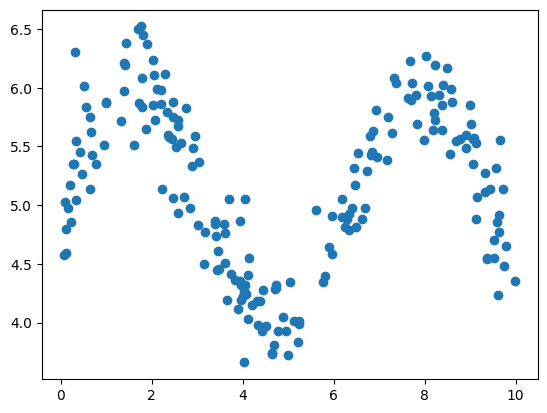

In [37]:
def produce_batch(batch_size, noise=0.3):
    xs = np.random.random(size=[batch_size, 1]) * 10
    ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
    return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)

In [38]:
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])

    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

In [40]:
tf.compat.v1.disable_eager_execution()

ckpt_dir = '/tmp/regression_model/'

with tf.compat.v1.Graph().as_default():
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

    inputs, targets = convert_data_to_tensors(x_train, y_train)

    # Make the model.
    predictions, nodes = regression_model(inputs, is_training=True)

    # Add the loss function to the graph.
    loss = tf.compat.v1.losses.mean_squared_error(labels=targets, predictions=predictions)

    # The total loss is the user's loss plus any regularization losses.
    total_loss = slim.losses.get_total_loss()

    # Specify the optimizer and create the train op:
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.005)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training inside a session.
    with tf.compat.v1.Session() as sess:
        final_loss = slim.learning.train(
            train_op,
            logdir=ckpt_dir,
            number_of_steps=5000,
            save_summaries_secs=5,
            log_every_n_steps=500)

print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

INFO:tensorflow:Restoring parameters from /tmp/regression_model/model.ckpt-0
Instructions for updating:
Use standard file utilities to get mtimes.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to path /tmp/regression_model/model.ckpt
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global step 499: loss = 0.3548 (0.001 sec/step)
INFO:tensorflow:global step 999: loss = 0.3270 (0.001 sec/step)
INFO:tensorflow:global step 1499: loss = 0.2775 (0.001 sec/step)
INFO:tensorflow:global step 1999: loss = 0.2791 (0.001 sec/step)
INFO:tensorflow:global step 2499: loss = 0.2257 (0.001 sec/step)
INFO:tensorflow:global step 2999: loss = 0.1960 (0.001 sec/step)
INFO:tensorflow:global step 3499: loss = 0.2136 (0.001 sec/step)
INFO:tensorflow:global step 3999: loss = 0.2116 (0.001 sec/step)
INFO:tensorflow:global_step/sec: 867.103
INFO:tensorflow:global step 4499: 

Finished training. Last batch loss: 0.19552338
Checkpoint saved in /tmp/regression_model/


In [41]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_train, y_train)
    predictions, end_points = regression_model(inputs, is_training=True)

    # Add multiple loss nodes.
    mean_squared_error_loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    absolute_difference_loss = slim.losses.absolute_difference(predictions, targets)

    # The following two ways to compute the total loss are equivalent
    regularization_loss = tf.add_n(slim.losses.get_regularization_losses())
    total_loss1 = mean_squared_error_loss + absolute_difference_loss + regularization_loss

    # Regularization Loss is included in the total loss by default.
    # This is good for training, but not for testing.
    total_loss2 = slim.losses.get_total_loss(add_regularization_losses=True)

    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op) # Will initialize the parameters with random weights.

        total_loss1, total_loss2 = sess.run([total_loss1, total_loss2])

        print('Total Loss1: %f' % total_loss1)
        print('Total Loss2: %f' % total_loss2)

        print('Regularization Losses:')
        for loss in slim.losses.get_regularization_losses():
            print(loss)

        print('Loss Functions:')
        for loss in slim.losses.get_losses():
            print(loss)

Instructions for updating:
Use tf.losses.absolute_difference instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.losses.add_loss instead.


Total Loss1: 34.460613
Total Loss2: 34.460613
Regularization Losses:
Tensor("deep_regression/fc1/kernel/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Tensor("deep_regression/fc2/kernel/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Tensor("deep_regression/prediction/kernel/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Loss Functions:
Tensor("mean_squared_error/value:0", shape=(), dtype=float32)
Tensor("absolute_difference/value:0", shape=(), dtype=float32)


INFO:tensorflow:Restoring parameters from /tmp/regression_model/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path /tmp/regression_model/model.ckpt
INFO:tensorflow:Starting queue runners.


Text(0.5, 1.0, 'red=true, blue=predicted')

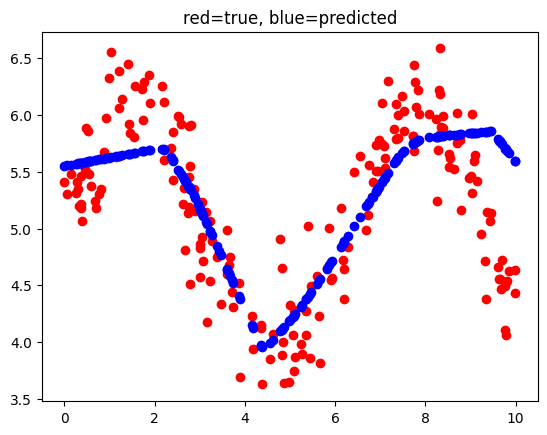

In [42]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)

    # Create the model structure. (Parameters will be loaded below.)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, targets = sess.run([inputs, predictions, targets])

plt.scatter(inputs, targets, c='r');
plt.scatter(inputs, predictions, c='b');
plt.title('red=true, blue=predicted')


In [49]:
tf.disable_v2_behavior()

ckpt_dir = '/tmp/regression_model/'

# Ensure the checkpoint directory exists
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Specify metrics to evaluate
    names_to_value_nodes, names_to_update_nodes = slim.metrics.aggregate_metric_map({
        'Mean Squared Error': slim.metrics.streaming_mean_squared_error(predictions, targets),
        'Mean Absolute Error': slim.metrics.streaming_mean_absolute_error(predictions, targets)
    })

    # Create a saver to restore the model
    saver = tf.train.Saver()

    # Initialization operations
    init_op = tf.global_variables_initializer()
    local_init_op = tf.local_variables_initializer()

    with tf.Session() as sess:
        # Initialize variables
        sess.run(init_op)
        sess.run(local_init_op)

        # Restore the model from the checkpoint
        checkpoint_path = tf.train.latest_checkpoint(ckpt_dir)
        if checkpoint_path:
            saver.restore(sess, checkpoint_path)
            print(f'Restored from {checkpoint_path}')
        else:
            print('No checkpoint found!')

        # Evaluate the metrics
        for _ in range(1):  # Single pass over data
            sess.run(list(names_to_update_nodes.values()))

        metric_values = sess.run(list(names_to_value_nodes.values()))

    names_to_values = dict(zip(names_to_value_nodes.keys(), metric_values))
    for key, value in names_to_values.items():
        print('%s: %f' % (key, value))

INFO:tensorflow:Restoring parameters from /tmp/regression_model/model.ckpt


Restored from /tmp/regression_model/model.ckpt
Mean Squared Error: 0.242227
Mean Absolute Error: 0.371145


In [52]:
import tensorflow.compat.v1 as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir)

>> Downloading flowers.tar.gz 100.0%
Successfully downloaded flowers.tar.gz 228649660 bytes.
/content/TF_model/models/research/slim


In [61]:
import tensorflow_datasets as tfds

flowers_data_dir = '/tmp/flowers'

# Load the dataset using TensorFlow Datasets
dataset = tfds.load('tf_flowers', split='train', data_dir=flowers_data_dir)

# Function to decode and resize images
def decode_and_resize(example):
    image = example['image']
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure images are decoded as JPEG format
    image = tf.image.resize(image, [224, 224])        # Resize image to expected shape
    image = tf.cast(image, tf.float32)                # Cast to float32
    image /= 255.0                                    # Normalize pixel values
    example['image'] = image
    return example

# Apply preprocessing steps to dataset
dataset = dataset.map(decode_and_resize)
dataset = dataset.shuffle(buffer_size=1000).batch(32)

# Iterate through the dataset and display images
for batch in dataset.take(1):  # Take one batch for demonstration
    images = batch['image']
    labels = batch['label']

    for i in range(len(images)):
        plt.figure()
        plt.imshow(images[i].numpy())
        plt.title('Label: {}'.format(labels[i].numpy()))
        plt.axis('off')
        plt.show()

TypeError: in user code:

    File "<ipython-input-61-d406b80f1a72>", line 11, in decode_and_resize  *
        image = tf.image.decode_jpeg(image, channels=3)  # Ensure images are decoded as JPEG format

    TypeError: Input 'contents' of 'DecodeJpeg' Op has type uint8 that does not match expected type of string.
